# Learn the globally optimal proposal for a linear gaussian state space model

We reproduce the experiment in Naesseth and al. Variational SMC

In [1]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pykalman
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2

seaborn.set()


In [2]:
tf.config.set_visible_devices([], 'GPU') 

In [3]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationModel

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.base import ProposalModelBase

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import PetkovSolver, NaiveSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

### Set up the model

In [4]:
tf.random.set_seed(0)
np.random.seed(1)

T = 25

d_x = 10
d_y = 10
alpha = 0.42
gamma = 0.1

B = 1
N = 4

transition_matrix = np.array([[alpha**(abs(i-j) + 1) for j in range(d_x)] for i in range(d_x)], dtype=np.float32)
transition_covariance = gamma**2 * np.eye(d_x, dtype=np.float32)

observation_matrix = np.zeros([d_y, d_x], dtype=np.float32)
observation_matrix[:d_y, :d_y] = np.eye(d_y, dtype=np.float32)
observation_covariance = np.eye(d_y, dtype=np.float32)

observation_matrix = np.ones([d_y, d_x], dtype=np.float32)


initial_state_mean = np.zeros(d_x, dtype=np.float32)
initial_state_covariance = np.eye(d_x, dtype=np.float32)

kf = pykalman.KalmanFilter(transition_matrix, observation_matrix, transition_covariance, observation_covariance, initial_state_mean=initial_state_mean, initial_state_covariance=initial_state_covariance)
observations = kf.sample(T)[1].data.astype(np.float32)

true_log_likelihood = kf.loglikelihood(observations)
true_log_likelihood

-374.0853015224544

In [5]:
observations_dataset = tf.data.Dataset.from_tensor_slices(observations)

### Set up the filterflow filter

In [6]:
transition_noise = tfd.MultivariateNormalDiag(tf.zeros(d_x, dtype=tf.float32), tf.linalg.diag_part(transition_covariance) ** 0.5) # mind it MultivariateNormalDiag does diag * diag...
transition_model = RandomWalkModel(tf.convert_to_tensor(transition_matrix), transition_noise)

In [7]:
observation_error = tfd.MultivariateNormalDiag(tf.zeros(d_y, dtype=tf.float32), tf.linalg.diag_part(observation_covariance) ** 0.5) # mind it MultivariateNormalDiag does diag * diag...
observation_model = LinearObservationModel(tf.convert_to_tensor(observation_matrix), observation_error)

In [8]:
class LearnableProposalModel(ProposalModelBase):
    def __init__(self, transition_matrix, name='LearnableProposalModel'):
        super(LearnableProposalModel, self).__init__(name=name)
        self._transition_matrix = transition_matrix
        self._standard_noise = tfd.MultivariateNormalDiag(tf.zeros(transition_matrix.shape[0]), tf.ones(transition_matrix.shape[0]))
    
    def propose(self, state: State, inputs, _observation: tf.Tensor):
        """See base class"""
        mu_t, beta_t, sigma_t = inputs
        
        transition = beta_t * tf.linalg.matvec(self._transition_matrix, state.particles)
        proposed_particles = mu_t + transition + sigma_t * self._standard_noise.sample([state.batch_size, state.n_particles])
        return attr.evolve(state, particles=proposed_particles)

    def loglikelihood(self, proposed_state: State, state: State, inputs: tf.Tensor, observation: tf.Tensor):
        """Interface method for particle proposal
        :param proposed_state: State
            proposed state
        :param state: State
            previous particle filter state
        :param inputs: tf.Tensor
            Control variables (time elapsed, some environment variables, etc)
        :param observation: tf.Tensor
            Look ahead observation for adapted particle proposal
        :return: proposed State
        :rtype: tf.Tensor
        """            
        mu_t, beta_t, sigma_t = inputs
        transition = beta_t * tf.linalg.matvec(self._transition_matrix, state.particles)
        
        scale = tfp.bijectors.Scale(sigma_t)
        scaled_rv = tfd.TransformedDistribution(self._standard_noise, bijector=scale)
        pushed_particles = mu_t + transition
        
        return scaled_rv.log_prob(pushed_particles - proposed_state.particles)

In [9]:
proposal_model = LearnableProposalModel(transition_matrix)
bootstrap_proposal = BootstrapProposalModel(transition_model)

In [10]:
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()

epsilon = tf.constant(0.5)
scaling = tf.constant(0.9)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4)

solver = PetkovSolver(tf.constant(30))
corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4, ricatti_solver=solver, propagate_correction_gradient=False)

    
systematic_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, systematic, correct_gradient=False)
regularized_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, regularized)
corrected_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, corrected)
bootstrap_smc = SMC(observation_model, transition_model, bootstrap_proposal, resampling_criterion, systematic)

In [11]:
initial_particles = tfd.MultivariateNormalDiag(initial_state_mean, tf.linalg.diag_part(initial_state_covariance)**0.5).sample([B, N])
uniform_weights = tf.ones([B, N])
uniform_weights = uniform_weights / tf.reduce_sum(uniform_weights, 1, keepdims=True)

uniform_log_weights = tf.math.log(uniform_weights)
log_likelihoods = tf.zeros([B])
initial_state = State(initial_particles, uniform_log_weights, uniform_weights, log_likelihoods, None, None)

### Create the learnable variables that will be used as inputs to the proposal

In [12]:
mu_ts = []
beta_ts = []
sigma_ts = []
for t in range(T):
    mu_ts.append(tf.Variable(0., trainable=True))
    beta_ts.append(tf.Variable(1., trainable=True))
    sigma_ts.append(tf.Variable(gamma, trainable=True))
    


In [13]:
trainable_variables = mu_ts + beta_ts + sigma_ts

In [14]:
@tf.function
def smc_routine(smc, use_correction_term=False):
    state = initial_state
    iterator = iter(observations_dataset)
    for t in range(T):
        mu_t = mu_ts[t]
        beta_t = beta_ts[t]
        sigma_t = sigma_ts[t]
        next_obs = iterator.get_next()
        state = smc.update(state, next_obs, [mu_t, beta_t, sigma_t])
    res = tf.reduce_mean(state.log_likelihoods)
    if use_correction_term:
        return res, tf.reduce_mean(state.resampling_correction)
    return res, tf.constant(0.)
    

In [15]:
smc_routine(bootstrap_smc)

(<tf.Tensor: shape=(), dtype=float32, numpy=-524.4864>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

In [16]:
%timeit smc_routine(systematic_smc)

4.02 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
@tf.function
def train_one_step(optimizer, smc, use_correction_term):
    with tf.GradientTape() as tape:
        tape.watch(trainable_variables)
        real_ll, correction = smc_routine(smc, use_correction_term)
        loss = -(real_ll + correction)
    grads_loss = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads_loss, trainable_variables))
    return real_ll, grads_loss

@tf.function
def train(optimizer, smc, num_steps = 101, use_correction_term=False):
    reset_operations = [mu_t.assign(0.) for mu_t in mu_ts] + [beta_t.assign(1.) for beta_t in beta_ts] + [sigma_t.assign(gamma) for sigma_t in sigma_ts]
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    with tf.control_dependencies(reset_operations):
        for step in tf.range(num_steps):
            real_ll, grads = train_one_step(optimizer, smc, use_correction_term)
            max_grad = tf.reduce_max(tf.abs(grads))
            tf.print('Step', step, '/', num_steps - 1, ': loss = ', real_ll, ', max abs grads = ', max_grad, end='\r')
            loss_tensor_array = loss_tensor_array.write(step, real_ll)
            grad_tensor_array = grad_tensor_array.write(step, max_grad)
    return loss_tensor_array.stack(), grad_tensor_array.stack()

In [18]:
adam = tf.optimizers.Adam(lr=0.01)

In [ ]:
ll, grads = train(adam, systematic_smc, tf.constant(1001))

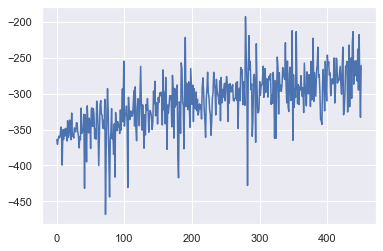

In [25]:
plt.plot(ll.numpy()[50:])

In [21]:
true_log_likelihood

-374.0853015224544

In [22]:
bootstrap_smc(initial_state, observations_dataset, tf.constant(T), True).log_likelihoods

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-385.4339], dtype=float32)>

In [23]:
sigma_ts

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.094749525>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.111417286>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.12429987>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.14126925>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.15875746>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.15544374>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.15191919>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.14811441>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.13803664>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.13961603>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.14003836>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.14532137>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.14673848>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1482178>,
 <tf.Variable 'Vari